In [ ]:
! pip install shap

In [ ]:
! pip install optuna

In [ ]:
! pip install optuna-integration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering  import
from sklearn.model_selection import train_test_split ,learning_curve

# Model import
import xgboost as xgb
from xgboost import XGBClassifier ,XGBRegressor

# Evaluate import
import optuna
import shap
# print the JS visualization code to the notebook
shap.plots.initjs()
from sklearn import metrics
from sklearn.metrics import accuracy_score ,roc_auc_score ,roc_curve ,classification_report ,confusion_matrix

# sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# Load Data

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
X = df.drop(columns =['Class'])
y = df['Class']

print('X:', X.shape) # (284807, 30)
print('Y:', y.shape) # (284807,)

In [ ]:
df.info()

In [ ]:
df.describe()

列出標籤個數，或是可以用圖表視覺化呈現

In [ ]:
counts = np.bincount(y)
for i, count in enumerate(counts):
    print(f"Class {i}: {count} instances")

Class 0: 284315 instances

Class 1: 492 instances

# Split Data

資料分割，將資料集拆分為訓練集和測試集，並使用stratify=y，讓訓練資料的分佈與測試資料產生相同的分佈。因為改變的類別的比例是一個嚴重的問題，因此訓練資料的分佈必須要與實際情況越接近越好。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 ,stratify=y)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

列出訓練資料和測試資料的標籤個數

In [ ]:
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 199020, 1: 344})

Testing target statistics: Counter({0: 85295, 1: 148})

In [ ]:
# # 訓練60%，驗證20%，測試20%
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# unique, counts = np.unique(y_test, return_counts=True)
# dict(zip(unique, counts))

# Optuna


In [ ]:
def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  # 訓練60%，驗證20%，測試20%
  # X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
  dtrain = xgb.DMatrix(X_train ,label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)
  # dval = xgb.DMatrix(X_val, label=y_val)
  params = {
    "verbosity": 0,
    'task': 'train',
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "tree_method": "exact",
    "booster": trial.suggest_categorical("booster", ["gbtree"]), # ,"dart" ,"gblinear" # optuna只接受gbtree
    # L2 regularization weight.
    "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    # L1 regularization weight.
    "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    # sampling ratio for training data.
    "subsample": trial.suggest_float("subsample", 0.2, 1.0),
    # sampling according to each tree.
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }
  if params["booster"] == "gbtree" or params["booster"] == "dart":
    # maximum depth of the tree, signifies complexity of the tree.
    params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
    # minimum child weight, larger the term more conservative the tree.
    params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    # defines how selective algorithm is.
    params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    # Additional parameters for Dart Booster
  if params["booster"] == "dart":
    params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  # Add a callback for pruning.
  # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc") # trial,"auc"
  # bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback]) # evals=[(dval, "validation")]
  bst = xgb.train(params, dtrain)
  preds = bst.predict(dtest)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_test, pred_labels)
  print("Accuracy:", accuracy)
  return accuracy

In [ ]:
# 最大化評估函數的返回值（例如準確率）時，應選擇 "maximize"
# 最小化評估函數的返回值（例如損失函數）時，應選擇 "minimize"
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

In [ ]:
trial.params

In [ ]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

從圖表中觀察Objective Value隨著每次Trial的變化情況，Trial為2時，Objective Value趨於Best Value(0.9994)



In [ ]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

*   從optuna輸出的視覺化圖表中我們可以發現 eta(learning_rate:學習速率)最為重要，其他依序為subsample(子樣本)，min_child_weight(葉子節點最小權重)，booster(助推器,可想像成樹的模型)。
*   max_depth(最大深度) 與 lambda(L2 正規化權重) 在此實作上無太大幫助。因此在下一次執行試驗的時候可以考慮將無用的參數移除，並將重要的超參數範圍加大取得更好的搜索結果。



最後將訓練好的params，傳遞給XGBClassifier，重新fit資料。

In [ ]:
xgb_clf = xgb.XGBClassifier(**trial.params)
# xgb_clf.fit(X, y)
xgb_clf.fit(X_train, y_train)

# Shap

解釋模型

In [ ]:
# Tree SHAP 來解釋整個資料集
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X)

In [ ]:
print("X shape:", X.shape)
print("SHAP values shape:", shap_values.shape)

X shape: (284807, 30)

SHAP values shape: (284807, 30)

In [ ]:
# waterfall 單筆資料解釋
shap.plots.waterfall(shap_values[0])

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X)

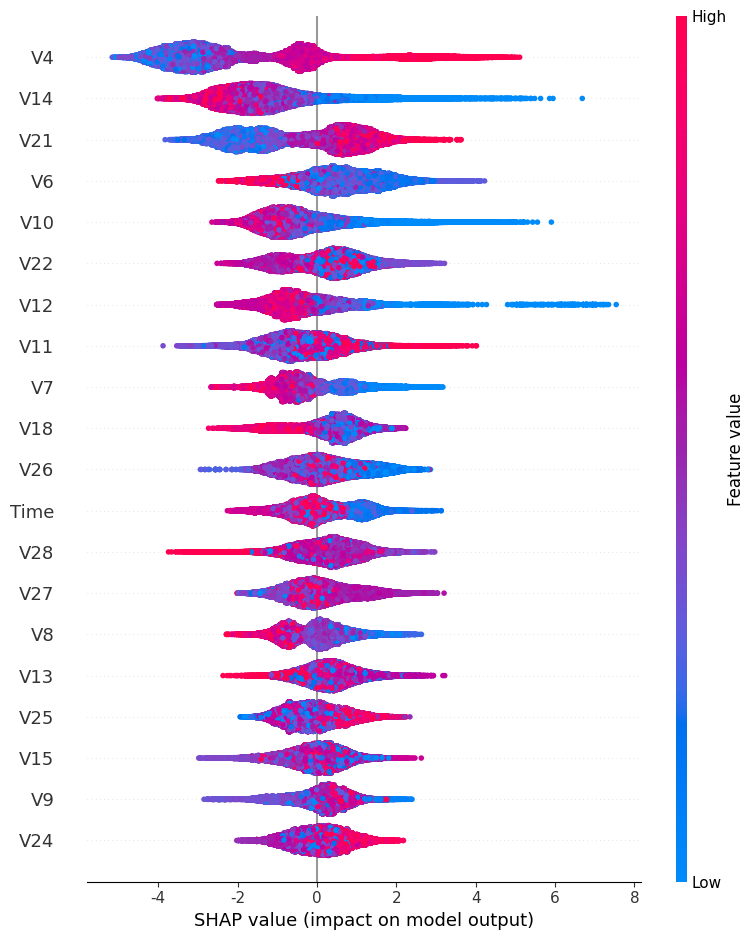

* V4越大，具有更大的總體模型影響
* V14越小，對於預測值的貢獻度越高，反之
* V21的大小,某種程度都會影響預測值




In [ ]:
# Bar chart of mean importance
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# Global bar plot
shap.plots.bar(shap_values)

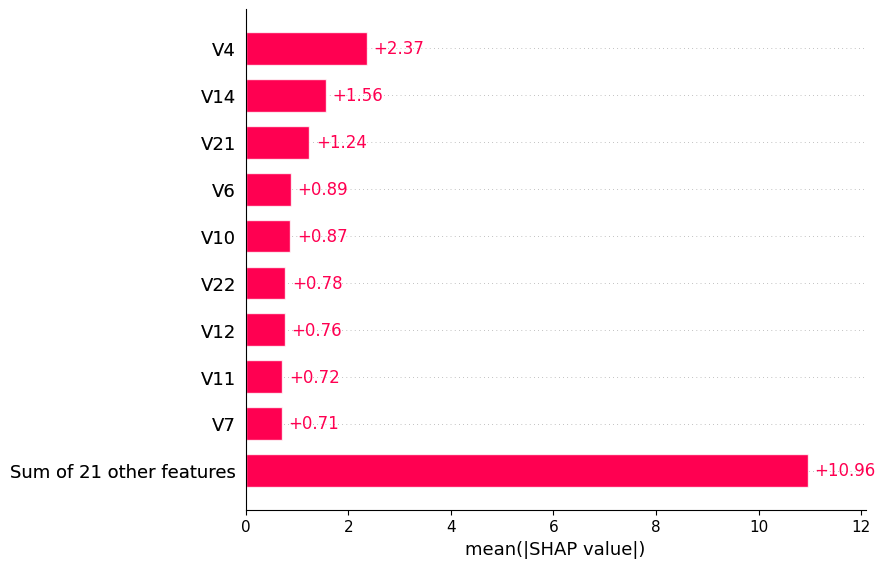

* V4：+2.37
* V14：+1.56
* V21：+1.24

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X_train)

# Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(xgb_clf, X_train, X_test, y_train, y_test)

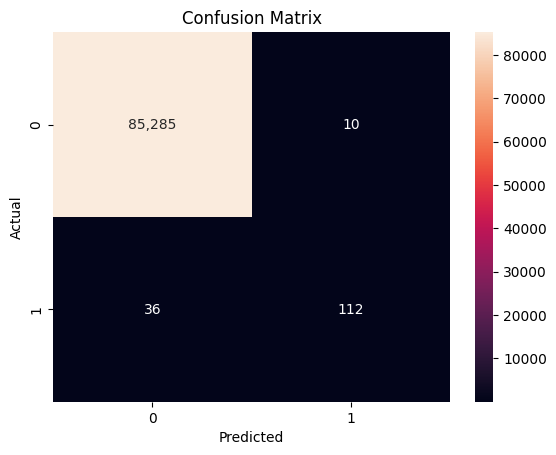

模型在訓練或是測試都表現良好，Testing Set中，預測沒有盜刷的precision達到1.00，有盜刷則是0.91，模型的Accuracy則達到了1.00，但評估結果不該只看Accuracy等其他指標，還需輸出混淆矩陣來查看。

*   真實盜刷資料總共有148筆，其中112筆被成功辨識出來，36筆沒有被辨識出來。
*   沒有被盜刷的資料總共有85295筆，其中有10筆資料沒到盜刷卻被預測為有盜刷，剩下的85285筆預測皆正確。




# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_clf, X_train, y_train)

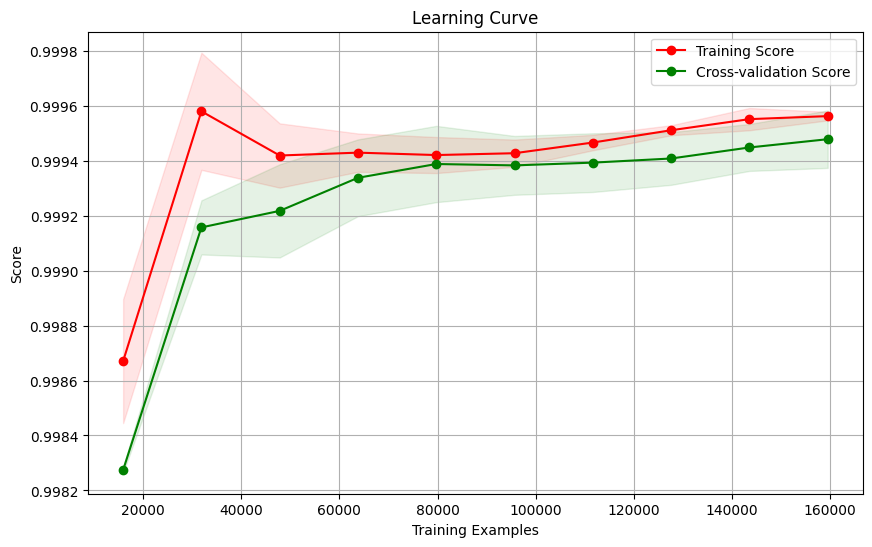

*   訓練分數的平均值逐漸增加，從約0.99867到約0.99956。這表示隨著訓練集的大小增加，模型在訓練集上的表現也在逐漸提高。
*   交叉驗證分數的平均值逐漸增加，從約0.99827到約0.99948。這表示隨著訓練集的大小增加，模型在交叉驗證集上的泛化能力也在逐漸提高。

